<a href="https://colab.research.google.com/github/anasCSD/Glaucoma-Segmentation/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch==0.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=00a9641fd03a6b02efeec56e7a5829cd14d3e7c3f14f27c322eb2ec2b54df7c8
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=233d01c0086470cd50acf80449d8e07f4fefe59c23941defce6ee8434003e90e
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built efficientnet-pytorc

In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.7 MB/s eta 0:00:00
time: 210 µs (started: 2025-12-13 14:48:37 +00:00)


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/AI_Project/Glaucoma_Segmentation"
SAVE_PATH = "/content/drive/MyDrive/AI_Project/Glaucoma_Model"
os.makedirs(SAVE_PATH, exist_ok=True)


time: 280 ms (started: 2025-12-13 14:50:17 +00:00)


In [ ]:
import os, cv2, numpy as np
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt


time: 4.2 s (started: 2025-12-13 14:50:51 +00:00)


In [ ]:
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.images = sorted(glob(os.path.join(image_dir, "*.png")) +
                             glob(os.path.join(image_dir, "*.jpg")))
        self.masks  = sorted(glob(os.path.join(mask_dir, "*.png")))
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = np.transpose(img, (2,0,1)).astype(np.float32)

        mask = cv2.imread(self.masks[idx], 0)
        mask = cv2.resize(mask, (self.img_size, self.img_size),
                          interpolation=cv2.INTER_NEAREST)
        mask = mask.astype(np.int64)   # {0,1,2}

        return torch.tensor(img), torch.tensor(mask)


time: 1.22 ms (started: 2025-12-13 14:51:12 +00:00)


In [ ]:
train_data = SegDataset(f"{DATASET_PATH}/train/images",
                        f"{DATASET_PATH}/train/masks")
val_data   = SegDataset(f"{DATASET_PATH}/val/images",
                        f"{DATASET_PATH}/val/masks")
test_data  = SegDataset(f"{DATASET_PATH}/test/images",
                        f"{DATASET_PATH}/test/masks")

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=1, shuffle=False)


time: 5.86 s (started: 2025-12-13 14:51:28 +00:00)


In [ ]:
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 222MB/s]


time: 10.6 s (started: 2025-12-13 14:51:45 +00:00)


In [ ]:
def segmentation_metrics(pred, true, num_classes=3):
    pred = torch.argmax(pred, dim=1)
    eps = 1e-8

    dice, iou = [], []
    for c in range(num_classes):
        p = (pred == c).float()
        t = (true == c).float()

        TP = (p * t).sum()
        FP = (p * (1 - t)).sum()
        FN = ((1 - p) * t).sum()

        dice_c = (2*TP) / (2*TP + FP + FN + eps)
        iou_c  = TP / (TP + FP + FN + eps)

        dice.append(dice_c.item())
        iou.append(iou_c.item())

    return np.array(dice), np.array(iou)


time: 963 µs (started: 2025-12-13 15:03:33 +00:00)


In [ ]:
EPOCHS = 50

history = {
    "train_loss": [], "val_loss": [],
    "train_dice": [], "val_dice": [],
    "train_iou": [],  "val_iou": []
}

best_val = 1e9

for epoch in range(EPOCHS):
    # -------- TRAIN --------
    model.train()
    tr_loss, tr_dice, tr_iou = 0, [], []

    for img, mask in train_loader:
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        dice, iou = segmentation_metrics(pred, mask)
        tr_dice.append(dice)
        tr_iou.append(iou)

    tr_loss /= len(train_loader)
    tr_dice = np.mean(tr_dice, axis=0)
    tr_iou  = np.mean(tr_iou, axis=0)

    # -------- VALIDATION --------
    model.eval()
    vl_loss, vl_dice, vl_iou = 0, [], []

    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)

            vl_loss += criterion(pred, mask).item()
            dice, iou = segmentation_metrics(pred, mask)
            vl_dice.append(dice)
            vl_iou.append(iou)

    vl_loss /= len(val_loader)
    vl_dice = np.mean(vl_dice, axis=0)
    vl_iou  = np.mean(vl_iou, axis=0)

    # -------- SAVE HISTORY --------
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(vl_loss)

    history["train_dice"].append(tr_dice[1:].mean())
    history["val_dice"].append(vl_dice[1:].mean())

    history["train_iou"].append(tr_iou[1:].mean())
    history["val_iou"].append(vl_iou[1:].mean())

    # -------- SAVE BEST --------
    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), f"{SAVE_PATH}/best_model.pth")

    # -------- PRINT --------
    print(f"""
Epoch {epoch+1}/{EPOCHS}
Train Loss: {tr_loss:.4f} | Val Loss: {vl_loss:.4f}
Train Dice (Disc/Cup): {tr_dice[1]:.3f}/{tr_dice[2]:.3f}
Val   Dice (Disc/Cup): {vl_dice[1]:.3f}/{vl_dice[2]:.3f}
Train mIoU (FG): {tr_iou[1:].mean():.3f}
Val   mIoU (FG): {vl_iou[1:].mean():.3f}
""")



Epoch 1/50
Train Loss: 0.0778 | Val Loss: 0.0495
Train Dice (Disc/Cup): 0.861/0.835
Val   Dice (Disc/Cup): 0.879/0.844
Train mIoU (FG): 0.739
Val   mIoU (FG): 0.760


Epoch 2/50
Train Loss: 0.0366 | Val Loss: 0.0298
Train Dice (Disc/Cup): 0.887/0.863
Val   Dice (Disc/Cup): 0.857/0.836
Train mIoU (FG): 0.779
Val   mIoU (FG): 0.737


Epoch 3/50
Train Loss: 0.0226 | Val Loss: 0.0233
Train Dice (Disc/Cup): 0.900/0.877
Val   Dice (Disc/Cup): 0.830/0.809
Train mIoU (FG): 0.801
Val   mIoU (FG): 0.699


Epoch 4/50
Train Loss: 0.0160 | Val Loss: 0.0160
Train Dice (Disc/Cup): 0.909/0.886
Val   Dice (Disc/Cup): 0.881/0.799
Train mIoU (FG): 0.815
Val   mIoU (FG): 0.729


Epoch 5/50
Train Loss: 0.0125 | Val Loss: 0.0127
Train Dice (Disc/Cup): 0.912/0.889
Val   Dice (Disc/Cup): 0.890/0.868
Train mIoU (FG): 0.820
Val   mIoU (FG): 0.786


Epoch 6/50
Train Loss: 0.0101 | Val Loss: 0.0112
Train Dice (Disc/Cup): 0.918/0.893
Val   Dice (Disc/Cup): 0.892/0.877
Train mIoU (FG): 0.829
Val   mIoU (FG): 0.795

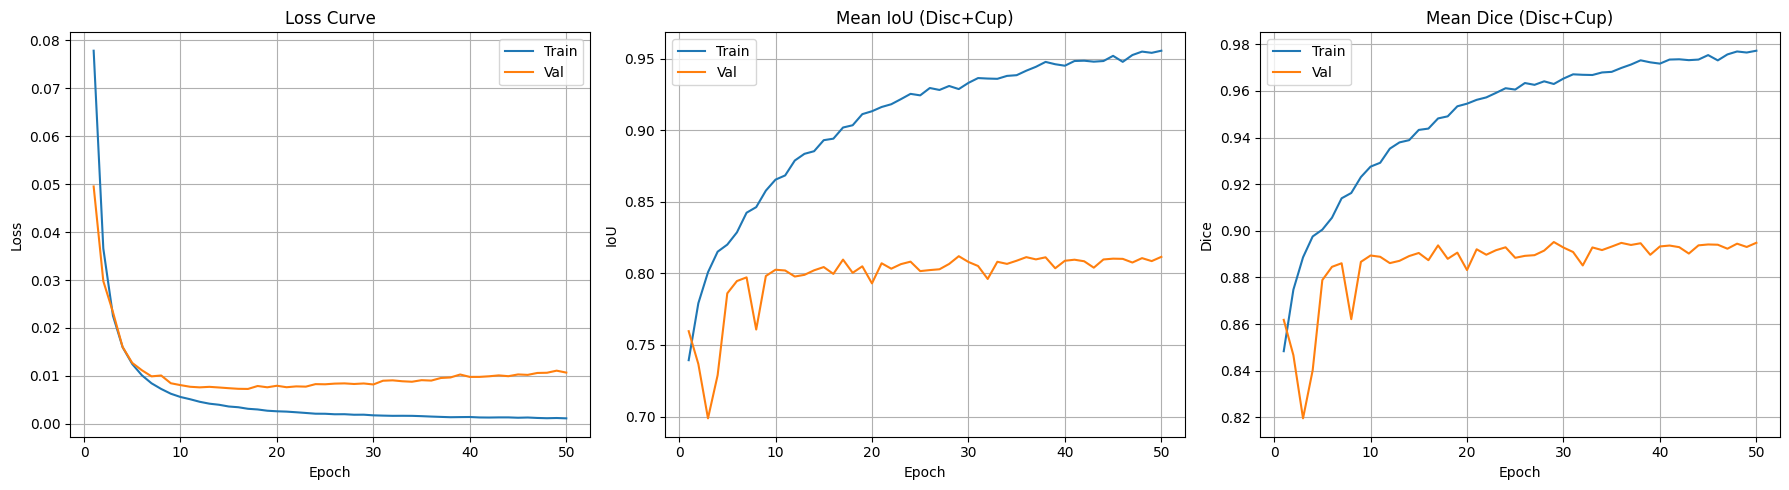

time: 510 ms (started: 2025-12-13 16:37:28 +00:00)


In [ ]:
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(18,5))

# ---- LOSS ----
plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"], label="Val")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# ---- IOU ----
plt.subplot(1,3,2)
plt.plot(epochs, history["train_iou"], label="Train")
plt.plot(epochs, history["val_iou"], label="Val")
plt.title("Mean IoU (Disc+Cup)")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid()

# ---- DICE ----
plt.subplot(1,3,3)
plt.plot(epochs, history["train_dice"], label="Train")
plt.plot(epochs, history["val_dice"], label="Val")
plt.title("Mean Dice (Disc+Cup)")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.load_state_dict(torch.load(f"{SAVE_PATH}/best_model.pth"))
model.eval()

test_dice, test_iou = [], []
cdrs, glaucoma_gt, glaucoma_pred = [], [], []

with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img)

        lbl = torch.argmax(pred, dim=1)[0]

        # ---- segmentation metrics ----
        dice, iou = segmentation_metrics(pred, mask)
        test_dice.append(dice)
        test_iou.append(iou)

        # ---- predicted CDR ----
        disc = (lbl == 1).sum().item()
        cup  = (lbl == 2).sum().item()

        if disc == 0:
            continue   # skip invalid sample

        vCDR = cup / disc
        cdrs.append(vCDR)
        glaucoma_pred.append(int(vCDR > 0.6))

        # ---- GT CDR ----
        gt_disc = (mask[0] == 1).sum().item()
        gt_cup  = (mask[0] == 2).sum().item()

        if gt_disc == 0:
            continue

        glaucoma_gt.append(int((gt_cup / gt_disc) > 0.6))


time: 6min 5s (started: 2025-12-13 16:38:04 +00:00)


In [ ]:
test_dice = np.mean(test_dice, axis=0)
test_iou  = np.mean(test_iou, axis=0)

acc = accuracy_score(glaucoma_gt, glaucoma_pred)
auc = roc_auc_score(glaucoma_gt, cdrs)

print("\n=== TEST RESULTS ===")
print(f"Disc Dice: {test_dice[1]:.4f}")
print(f"Cup  Dice: {test_dice[2]:.4f}")
print(f"Mean Dice (Disc+Cup): {test_dice[1:].mean():.4f}")
print(f"Glaucoma Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")



=== TEST RESULTS ===
Disc Dice: 0.9074
Cup  Dice: 0.8918
Mean Dice (Disc+Cup): 0.8996
Glaucoma Accuracy: 0.9500
ROC-AUC: 0.9343
time: 19.8 ms (started: 2025-12-13 16:44:19 +00:00)


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Class": ["Background","Disc","Cup"],
    "Dice": test_dice,
    "IoU": test_iou
})

df


,Class,Dice,IoU
0,Background,0.999356,0.998714
1,Disc,0.907357,0.834372
2,Cup,0.891814,0.808647


time: 10.4 ms (started: 2025-12-13 16:53:15 +00:00)


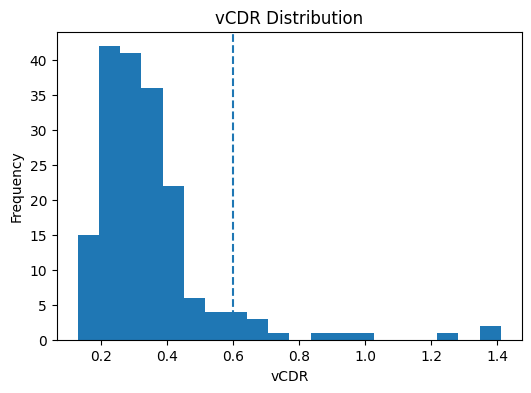

time: 131 ms (started: 2025-12-13 16:46:18 +00:00)


In [ ]:
#CDR histogram
plt.figure(figsize=(6,4))
plt.hist(cdrs, bins=20)
plt.axvline(0.6, linestyle="--")
plt.title("vCDR Distribution")
plt.xlabel("vCDR")
plt.ylabel("Frequency")
plt.show()


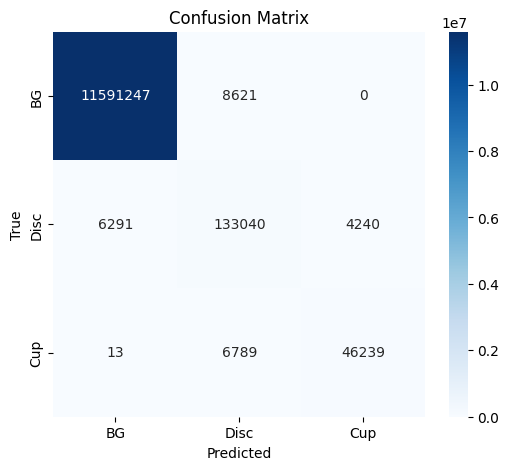

time: 19.6 s (started: 2025-12-13 16:46:24 +00:00)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_pred, all_true = [], []

model.eval()
with torch.no_grad():
    for img, mask in test_loader:
        img = img.to(device)
        pred = torch.argmax(model(img), dim=1).cpu().numpy().flatten()
        true = mask.numpy().flatten()

        all_pred.extend(pred)
        all_true.extend(true)

cm = confusion_matrix(all_true, all_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["BG","Disc","Cup"],
            yticklabels=["BG","Disc","Cup"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


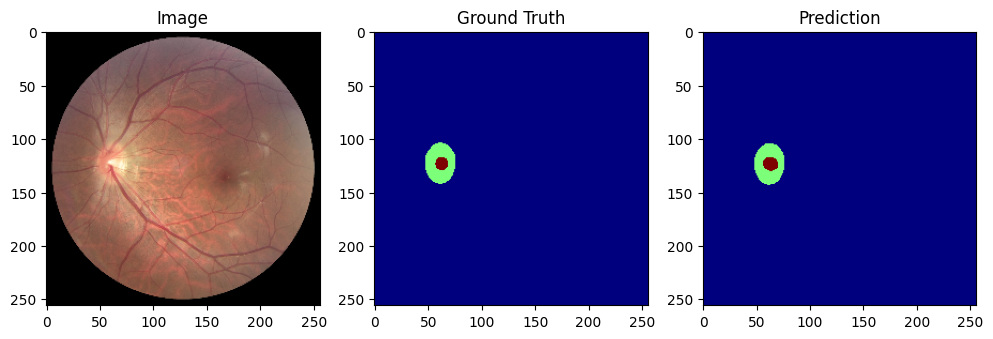

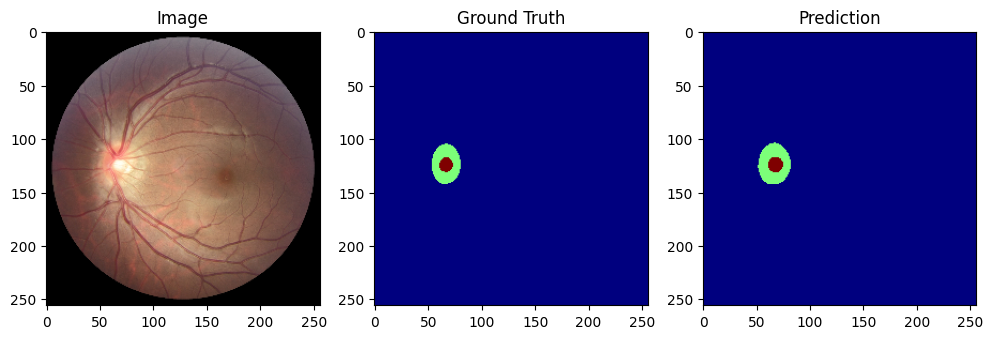

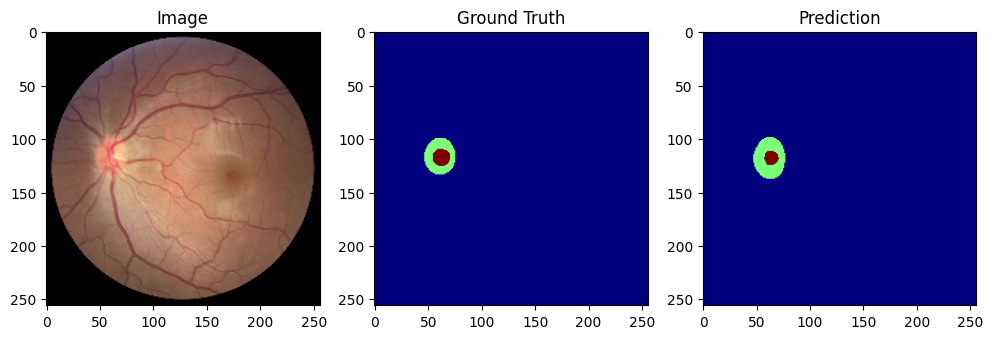

time: 1.31 s (started: 2025-12-13 16:47:24 +00:00)


In [ ]:
def visualize_predictions(model, loader, n=3):
    model.eval()
    for i, (img, mask) in enumerate(loader):
        if i >= n: break

        img = img.to(device)
        with torch.no_grad():
            pred = torch.argmax(model(img), dim=1)[0].cpu()

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img[0].cpu().permute(1,2,0))
        plt.title("Image")

        plt.subplot(1,3,2)
        plt.imshow(mask[0], cmap="jet", vmin=0, vmax=2)
        plt.title("Ground Truth")

        plt.subplot(1,3,3)
        plt.imshow(pred, cmap="jet", vmin=0, vmax=2)
        plt.title("Prediction")
        plt.show()

visualize_predictions(model, test_loader)
